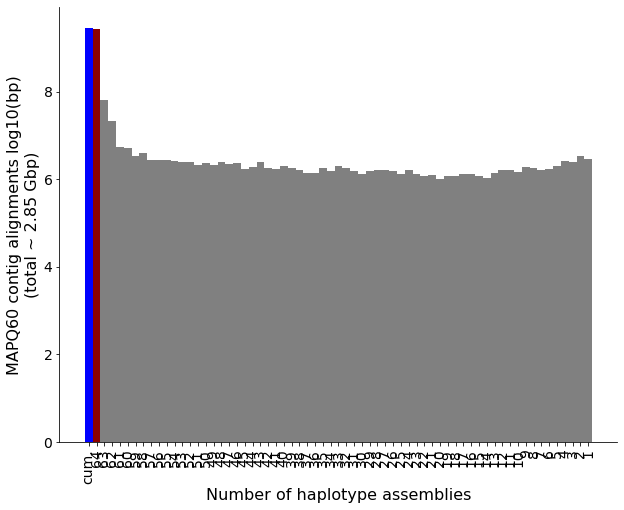

In [40]:
import os
import csv
import collections
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

save_plots = False
print_stats = False

stats_path = '/home/local/work/data/hgsvc/aln_summary/aln_64hap_hifi-prio.mapq60.bed'
out_path = os.path.join('/home/local/work/data/hgsvc/figSX_panels/aln_summary/figSX_panel_hapcov')

# input file requires counting alignment coverage first
# with script agg_contig_alns.py

df = pd.read_csv(
    stats_path,
    sep='\t',
    header=0,
    usecols=['start', 'end', 'num_hap']
)

df['length'] = df['end'] - df['start']

def plot_phasing_statistic(sample_stats):
    
    bar_width = 1

    fig, axis = plt.subplots(figsize=(10,8))
    
    x_labels = ['cum.']
    x_labels.extend(reversed([str(i) for i in range(1, 65)]))
    
    # sort from 64 to 1
    total_cov = np.array([sample_stats['length'].sum()], dtype=np.int64)
    
    hap_cov = np.append(total_cov, sample_stats.groupby('num_hap')['length'].sum().values[::-1])
    
#     rel_cov = hap_cov / total_cov[0]
#     rel_cov *= 100
#     rel_cov = rel_cov.round(2)

    rel_cov = np.log10(hap_cov)

    x_pos = list(range(0, 65))
    
    axis.bar(
        x_pos,
        rel_cov,
        bar_width,
        label='',
        color=['blue', 'darkred'] + ['grey'] * 63,
        align='center'
    )
    
    axis.set_xticks(x_pos)
    axis.set_xticklabels(x_labels, rotation=90)
    axis.set_xlabel(
        'Number of haplotype assemblies',
        fontsize=prop('fontsize_axis_label')
    )
    axis.set_ylabel(
        'MAPQ60 contig alignments log10(bp)\n(total ~ 2.85 Gbp)',
        fontsize=prop('fontsize_axis_label')
    )
        
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
#     # build custom legend
#     custom_patches = [
#         patches.Patch(facecolor='white', edgecolor='black',
#                       label='CLR'),
#         patches.Patch(facecolor='white', edgecolor='black',
#                       label='HiFi', hatch='/'),
#         patches.Patch(facecolor='black', edgecolor=None,
#                       label='unphased'),
#     ]
    
#     axis.legend(
#         handles=custom_patches,
#         loc='best',
#         handlelength=3,
#         handleheight=1,
#         prop={'size': prop('fontsize_legend')}
#     )
        
    return fig, []

fig, exart = plot_phasing_statistic(df)

if save_plots:
    fig.savefig(
        out_path + '_lowres.png',
        dpi=prop('dpi_low_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(
        out_path + '.png',
        dpi=prop('dpi_high_res'),
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)

if print_stats:
    print('==========')
    nhr_clr = df.xs('CLR', level='platform', drop_level=False)
    print('CLR stats')
    print(nhr_clr['het_snv'].describe())
    print('==========')
    nhr_hifi = df.xs('HiFi', level='platform', drop_level=False)
    print('NHR HiFi stats')
    print(nhr_hifi['het_snv'].describe())
    print('==========')

    afr = df.xs('AFR', level='super_pop', drop_level=False)
    print('AFR stats')
    print(afr['het_snv'].describe())
    print('==========')
    other = df.drop('AFR', level='super_pop', inplace=False)
    print('Other stats')
    print(other['het_snv'].describe())
